In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['figure.dpi'] = 150

import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.autolayout': True})

import seaborn as sns
sns.set(style='whitegrid', font_scale=0.9, rc={"lines.linewidth": 1.4,
                                           'lines.markersize': 1.6}, font="serif")

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='notebook', fscale=1, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size

from mpl_toolkits import mplot3d

/Users/sophia/.local/venv/maszcal/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  


In [5]:
from multiprocessing import Pool
import numpy as np
import astropy.stats
import supercubos
import corner
from sklearn.gaussian_process.kernels import Matern
import emcee
import maszcal.lensing
import maszcal.emulate
import maszcal.interpolate
import maszcal.likelihoods
import maszcal.fitutils
import maszcal.data.sims
import maszcal.data.obs
from maszcal.interp_utils import cartesian_prod

In [13]:
LOWER_RADIUS_CUT = 0.125
UPPER_RADIUS_CUT = 3

In [14]:
sim_data = maszcal.data.sims.NBatta2010('../data/NBatta2010/').cut_radii(LOWER_RADIUS_CUT, UPPER_RADIUS_CUT)

In [50]:
cov_magnitude = 4
cov = np.identity(sim_data.radii.size) * cov_magnitude
fisher = np.identity(sim_data.radii.size) / cov_magnitude
sim_errs = np.sqrt(np.diag(cov))
print(sim_errs)

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [17]:
zs = sim_data.redshifts[::-1]
mus = np.linspace(np.log(5e13), np.log(5e15), 30)

model = maszcal.lensing.BaryonCmShearModel(
    mu_bins=mus,
    redshift_bins=zs,
    cosmo_params=sim_data.cosmology,
    delta=500,
    mass_definition='crit',
)

rs = sim_data.radii

In [18]:
param_mins = np.array([0.1, 0.1, -2]) #alpha, beta, gamma, a_sz
param_maxes = np.array([6, 8.1, 2])

lh = supercubos.LatinSampler().get_lh_sample(param_mins, param_maxes, 200)

alphas = lh.T[0]
betas = lh.T[1]
gammas = np.array([0.2])
a_szs = lh.T[2]

esds = model.stacked_delta_sigma(rs, alphas, betas, gammas, a_szs)
data = rs[:, None] * esds

emulator = maszcal.emulate.PcaEmulator.create_from_data(
    coords=lh,
    data=data,
    interpolator_class=maszcal.interpolate.GaussianProcessInterpolator,
    interpolator_kwargs={'kernel': Matern()}
)

In [19]:
rand = supercubos.LatinSampler().get_rand_sample(
    param_mins=param_mins,
    param_maxes=param_maxes,
    num_samples=140,
)

alphas_check = rand.T[0]
betas_check = rand.T[1]
gammas_check = gammas
a_szs_check = rand.T[2]

esds_check = model.stacked_delta_sigma(rs, alphas_check, betas_check, gammas_check, a_szs_check)
data_check = rs[:, None] * esds_check

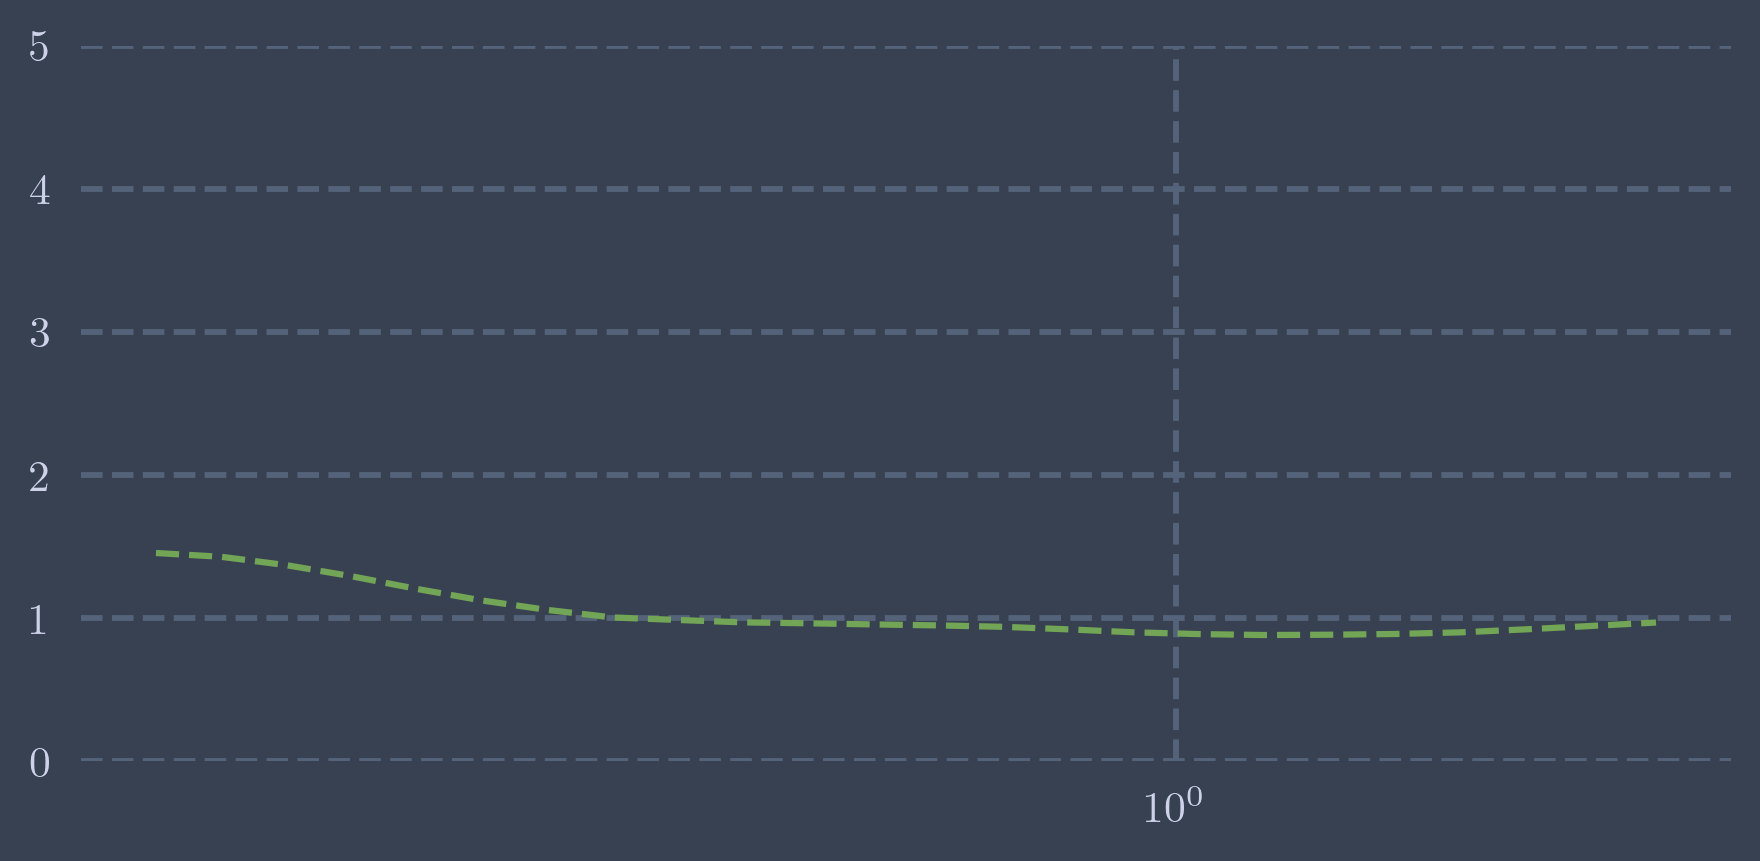

In [20]:
emulated_data = emulator(rand)
errs = (emulated_data - data_check)/data_check

colors = ['#72a555', '#ab62c0', '#c57c3c', '#638ccc', '#ca5670']

plt.plot(rs, 100*np.abs(errs).mean(axis=-1), color=colors[0], linestyle='--')
plt.ylim((0, 5))
plt.xscale('log')
plt.gcf().set_size_inches(6, 3)
pass

In [63]:
def log_like(params, data):
    model = emulator(params[None, :]).flatten()
    return maszcal.likelihoods.log_gaussian_shape(model, data, fisher)


def log_prob(params, data):
    if np.all(param_mins < params) and np.all(params < param_maxes):
        return log_like(params, data)
    else:
        return - np.inf

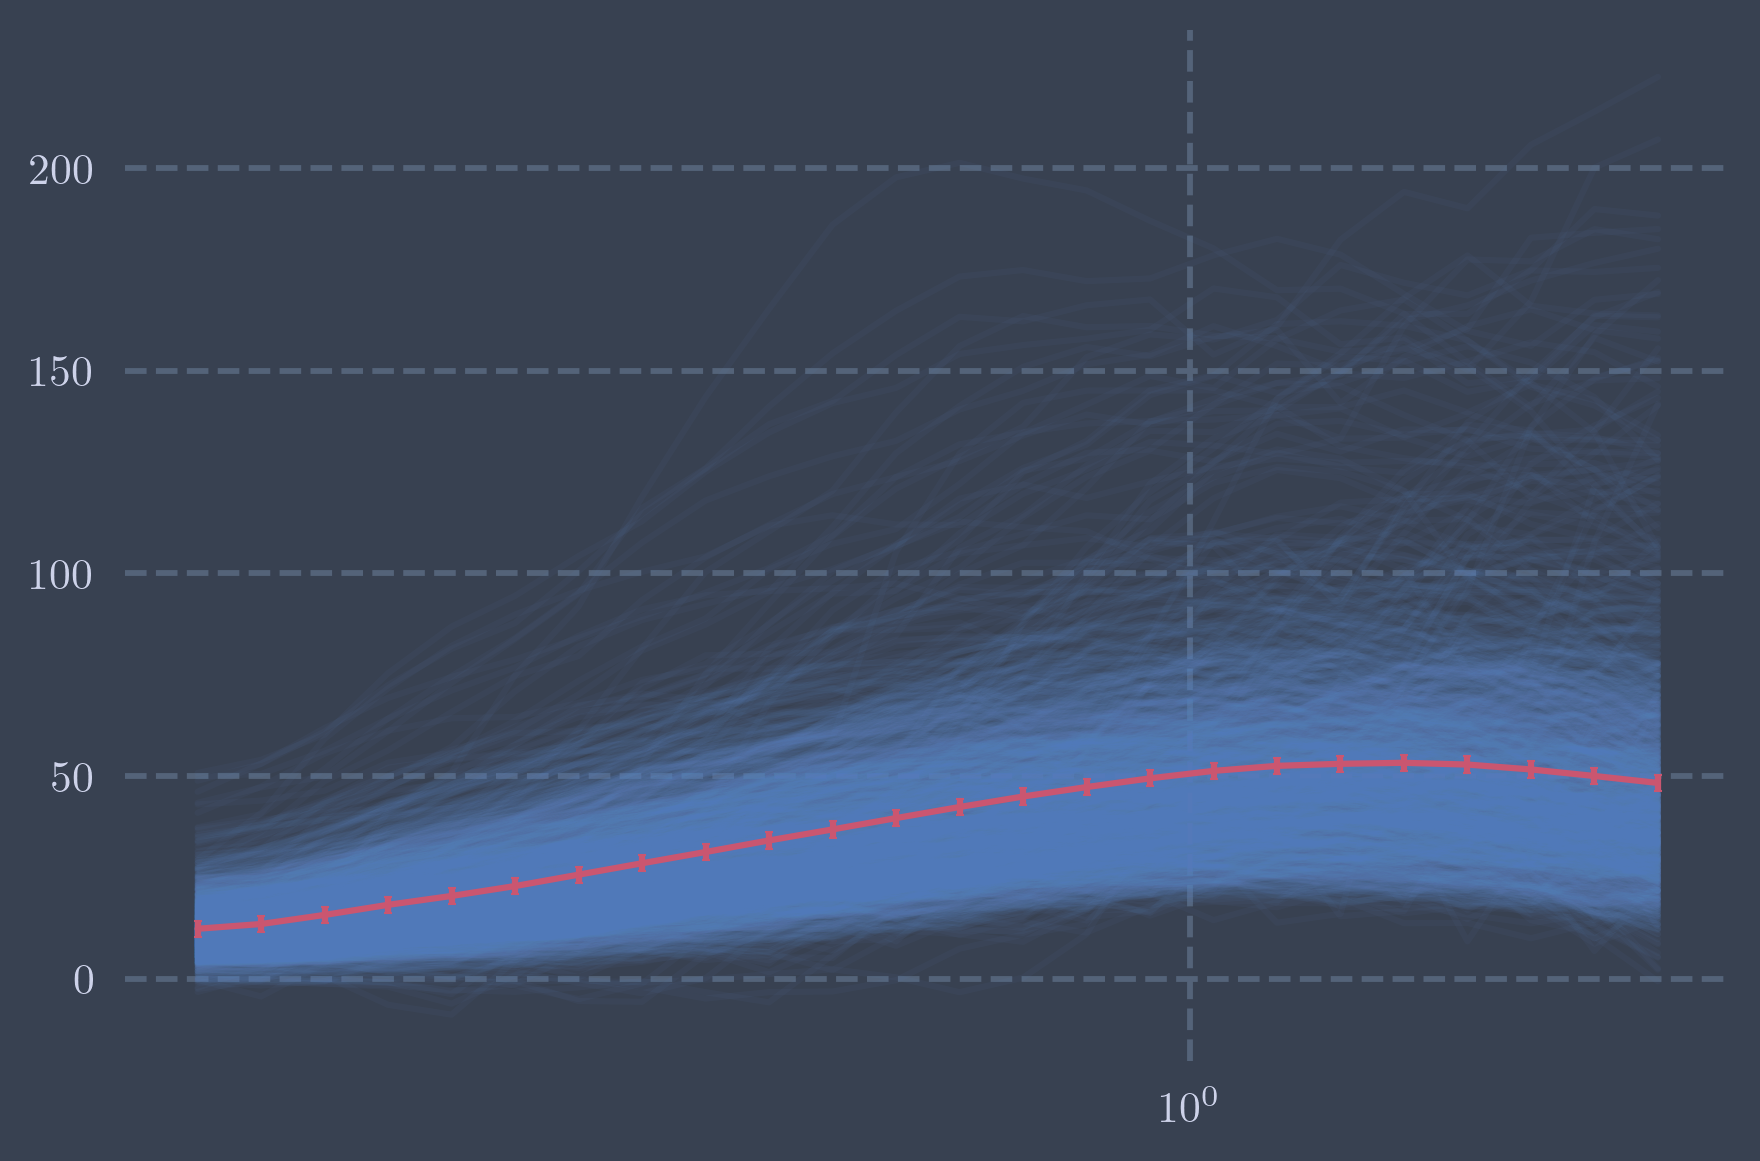

In [60]:
plt.plot(rs, rs[:, None]*sim_data.wl_signals.reshape(24, -1), color=colors[3], alpha=0.05,
         zorder=1)
sim_stack = rs * (sim_data.wl_signals.mean(axis=(1, 2)))
plt.errorbar(rs, sim_stack, yerr=sim_errs, color=colors[4], capsize=1, capthick=0.5)
plt.xscale('log')
plt.gcf().set_size_inches(6, 4)
pass

In [64]:
best_fit = maszcal.fitutils.global_minimize(
    lambda p: -log_like(p, sim_stack),
    param_mins,
    param_maxes,
    method='global-differential-evolution',
)

In [65]:
best_fit

array([0.22748166, 3.64734594, 0.26256641])

In [67]:
import emcee

nwalkers, ndim = (500, 3)
pos = best_fit + 1e-4 * np.random.randn(nwalkers, ndim)
nsteps = 2400

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(sim_stack,), pool=pool)
    sampler.run_mcmc(pos, 2400, progress=True);

100%|██████████| 2400/2400 [03:08<00:00, 12.71it/s]


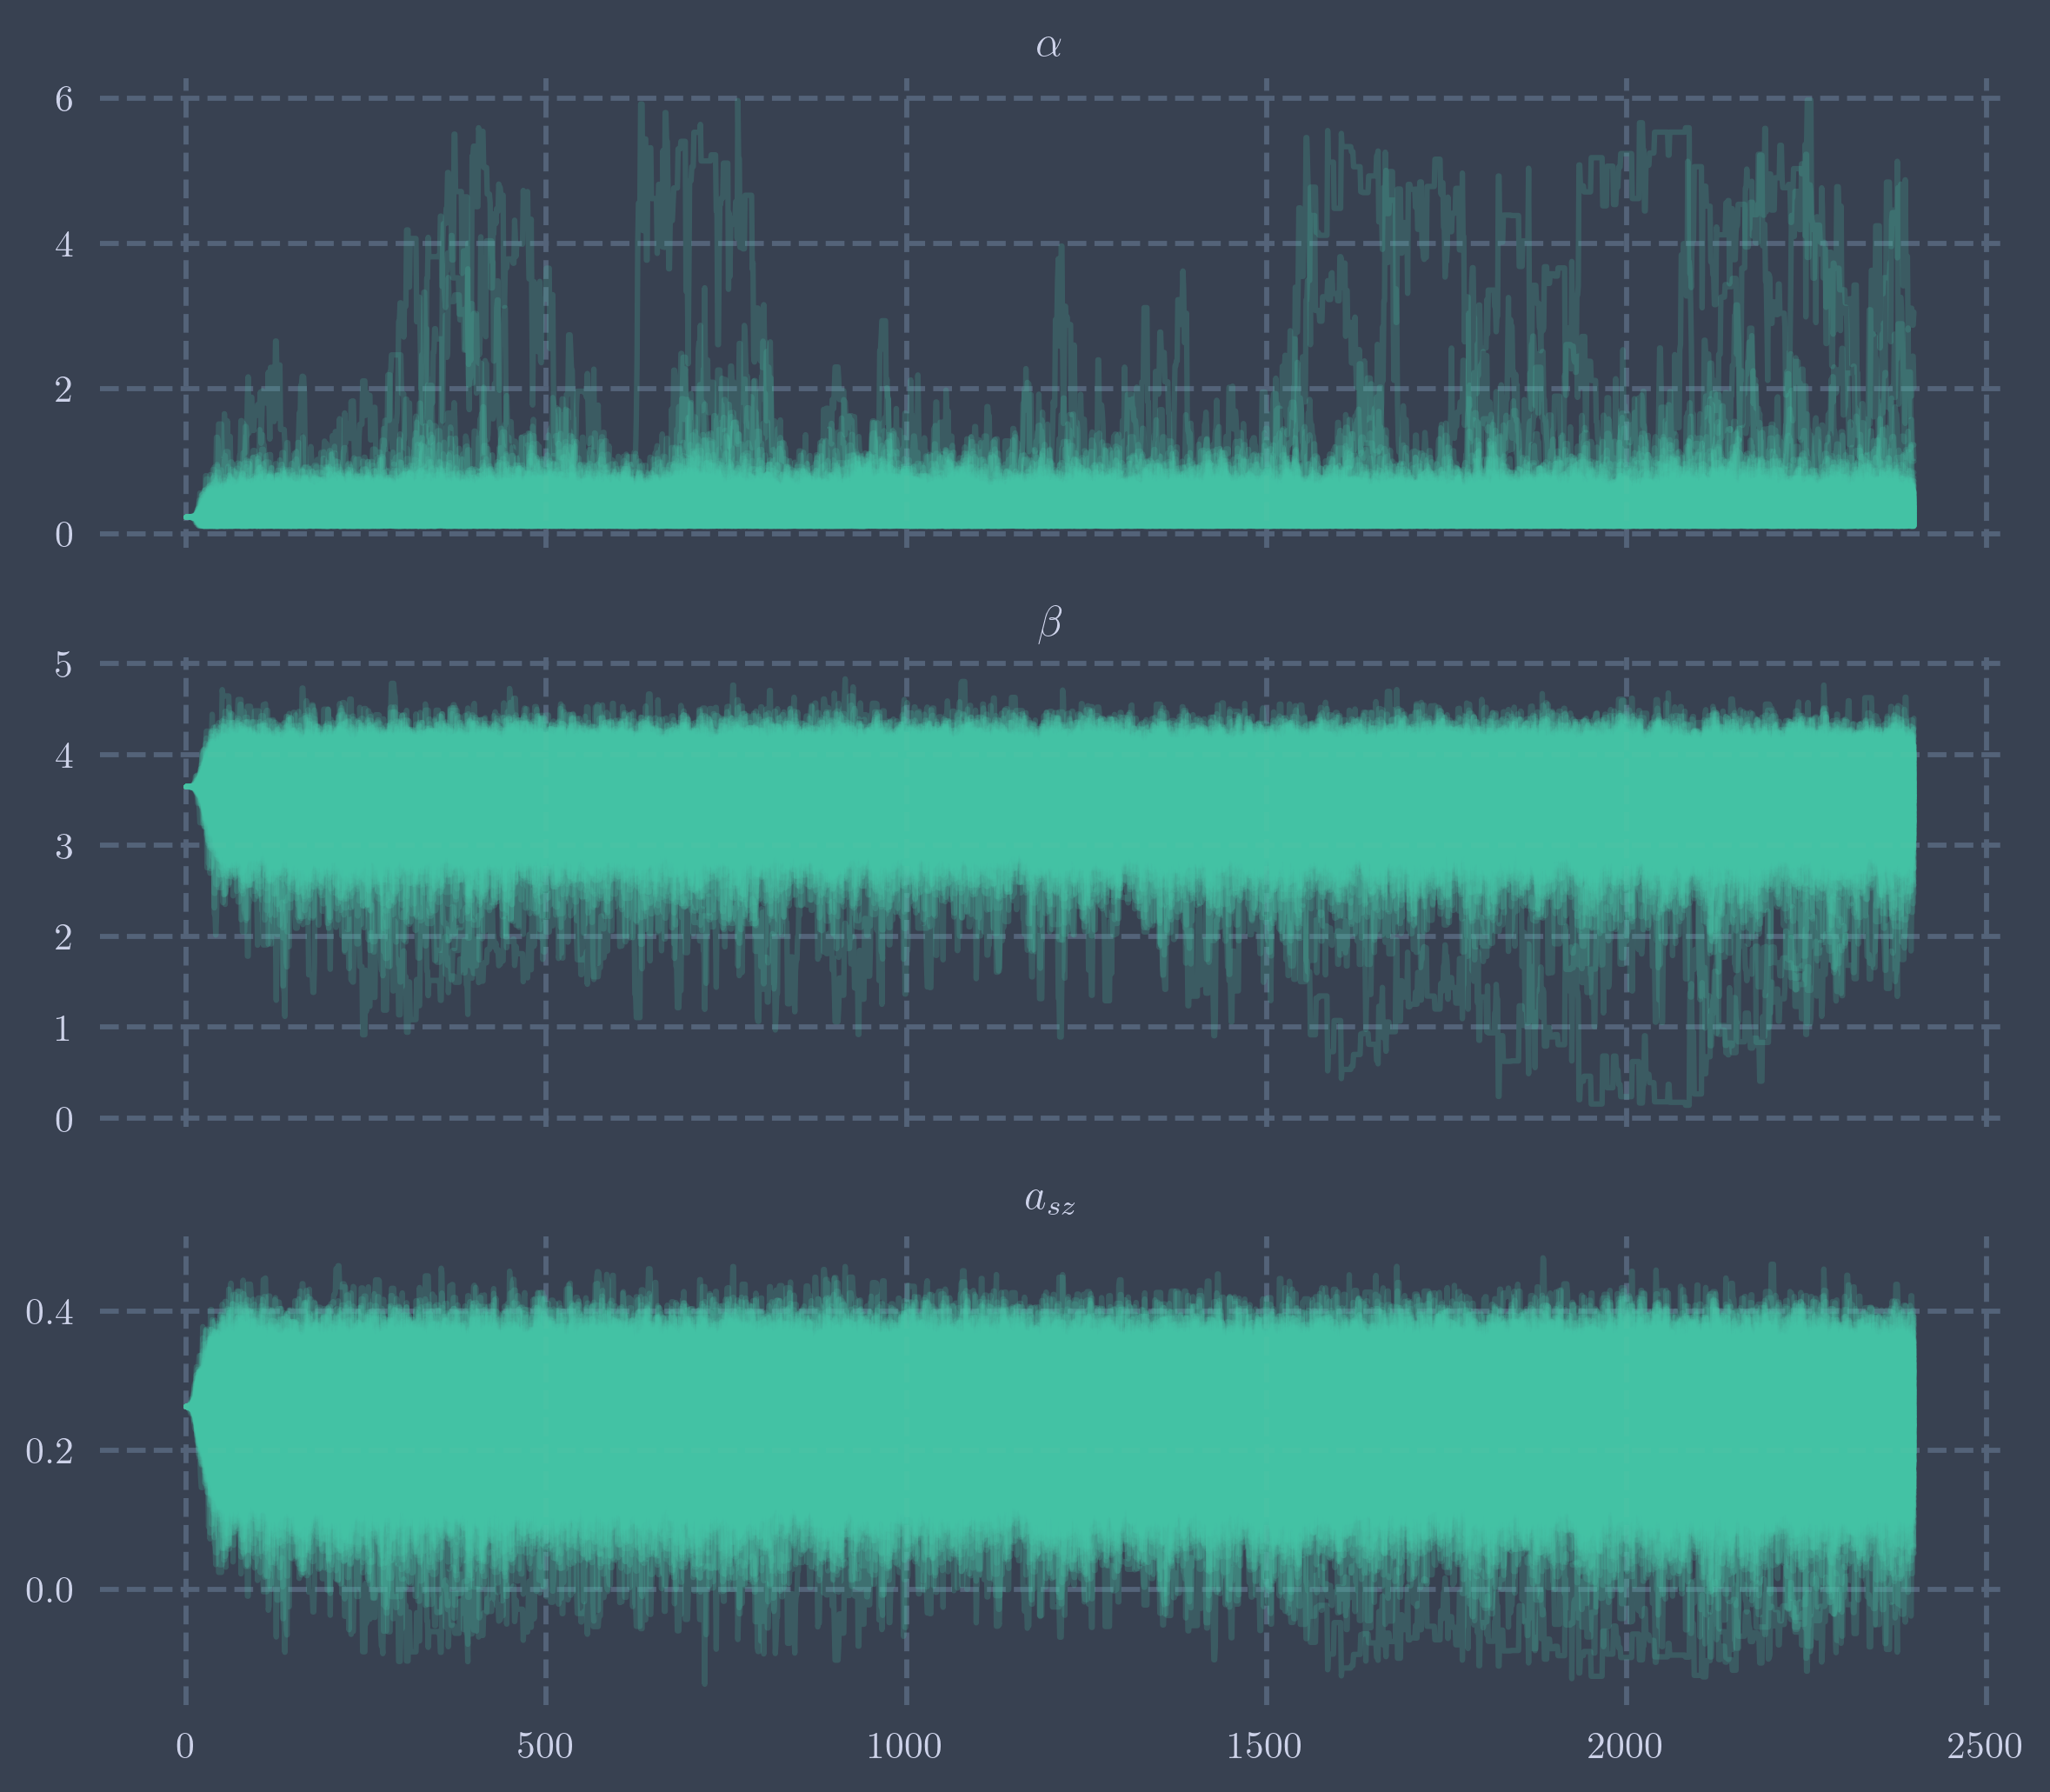

In [68]:
param_names = [r'$\alpha$', r'$\beta$', r'$a_{sz}$']
colors = ['#5b99e2', '#48c7a9']
fig,ax = plt.subplots(3, sharex=True)
for i in range(3):
    ax[i].plot(sampler.chain[:, :, i].T, color=colors[1], alpha=0.2)
    ax[i].set_title(param_names[i])

In [69]:
sampler.get_autocorr_time()

array([40.25136348, 38.77544892, 38.33102266])

In [70]:
flat_samples = sampler.get_chain(discard=400, thin=20, flat=True)

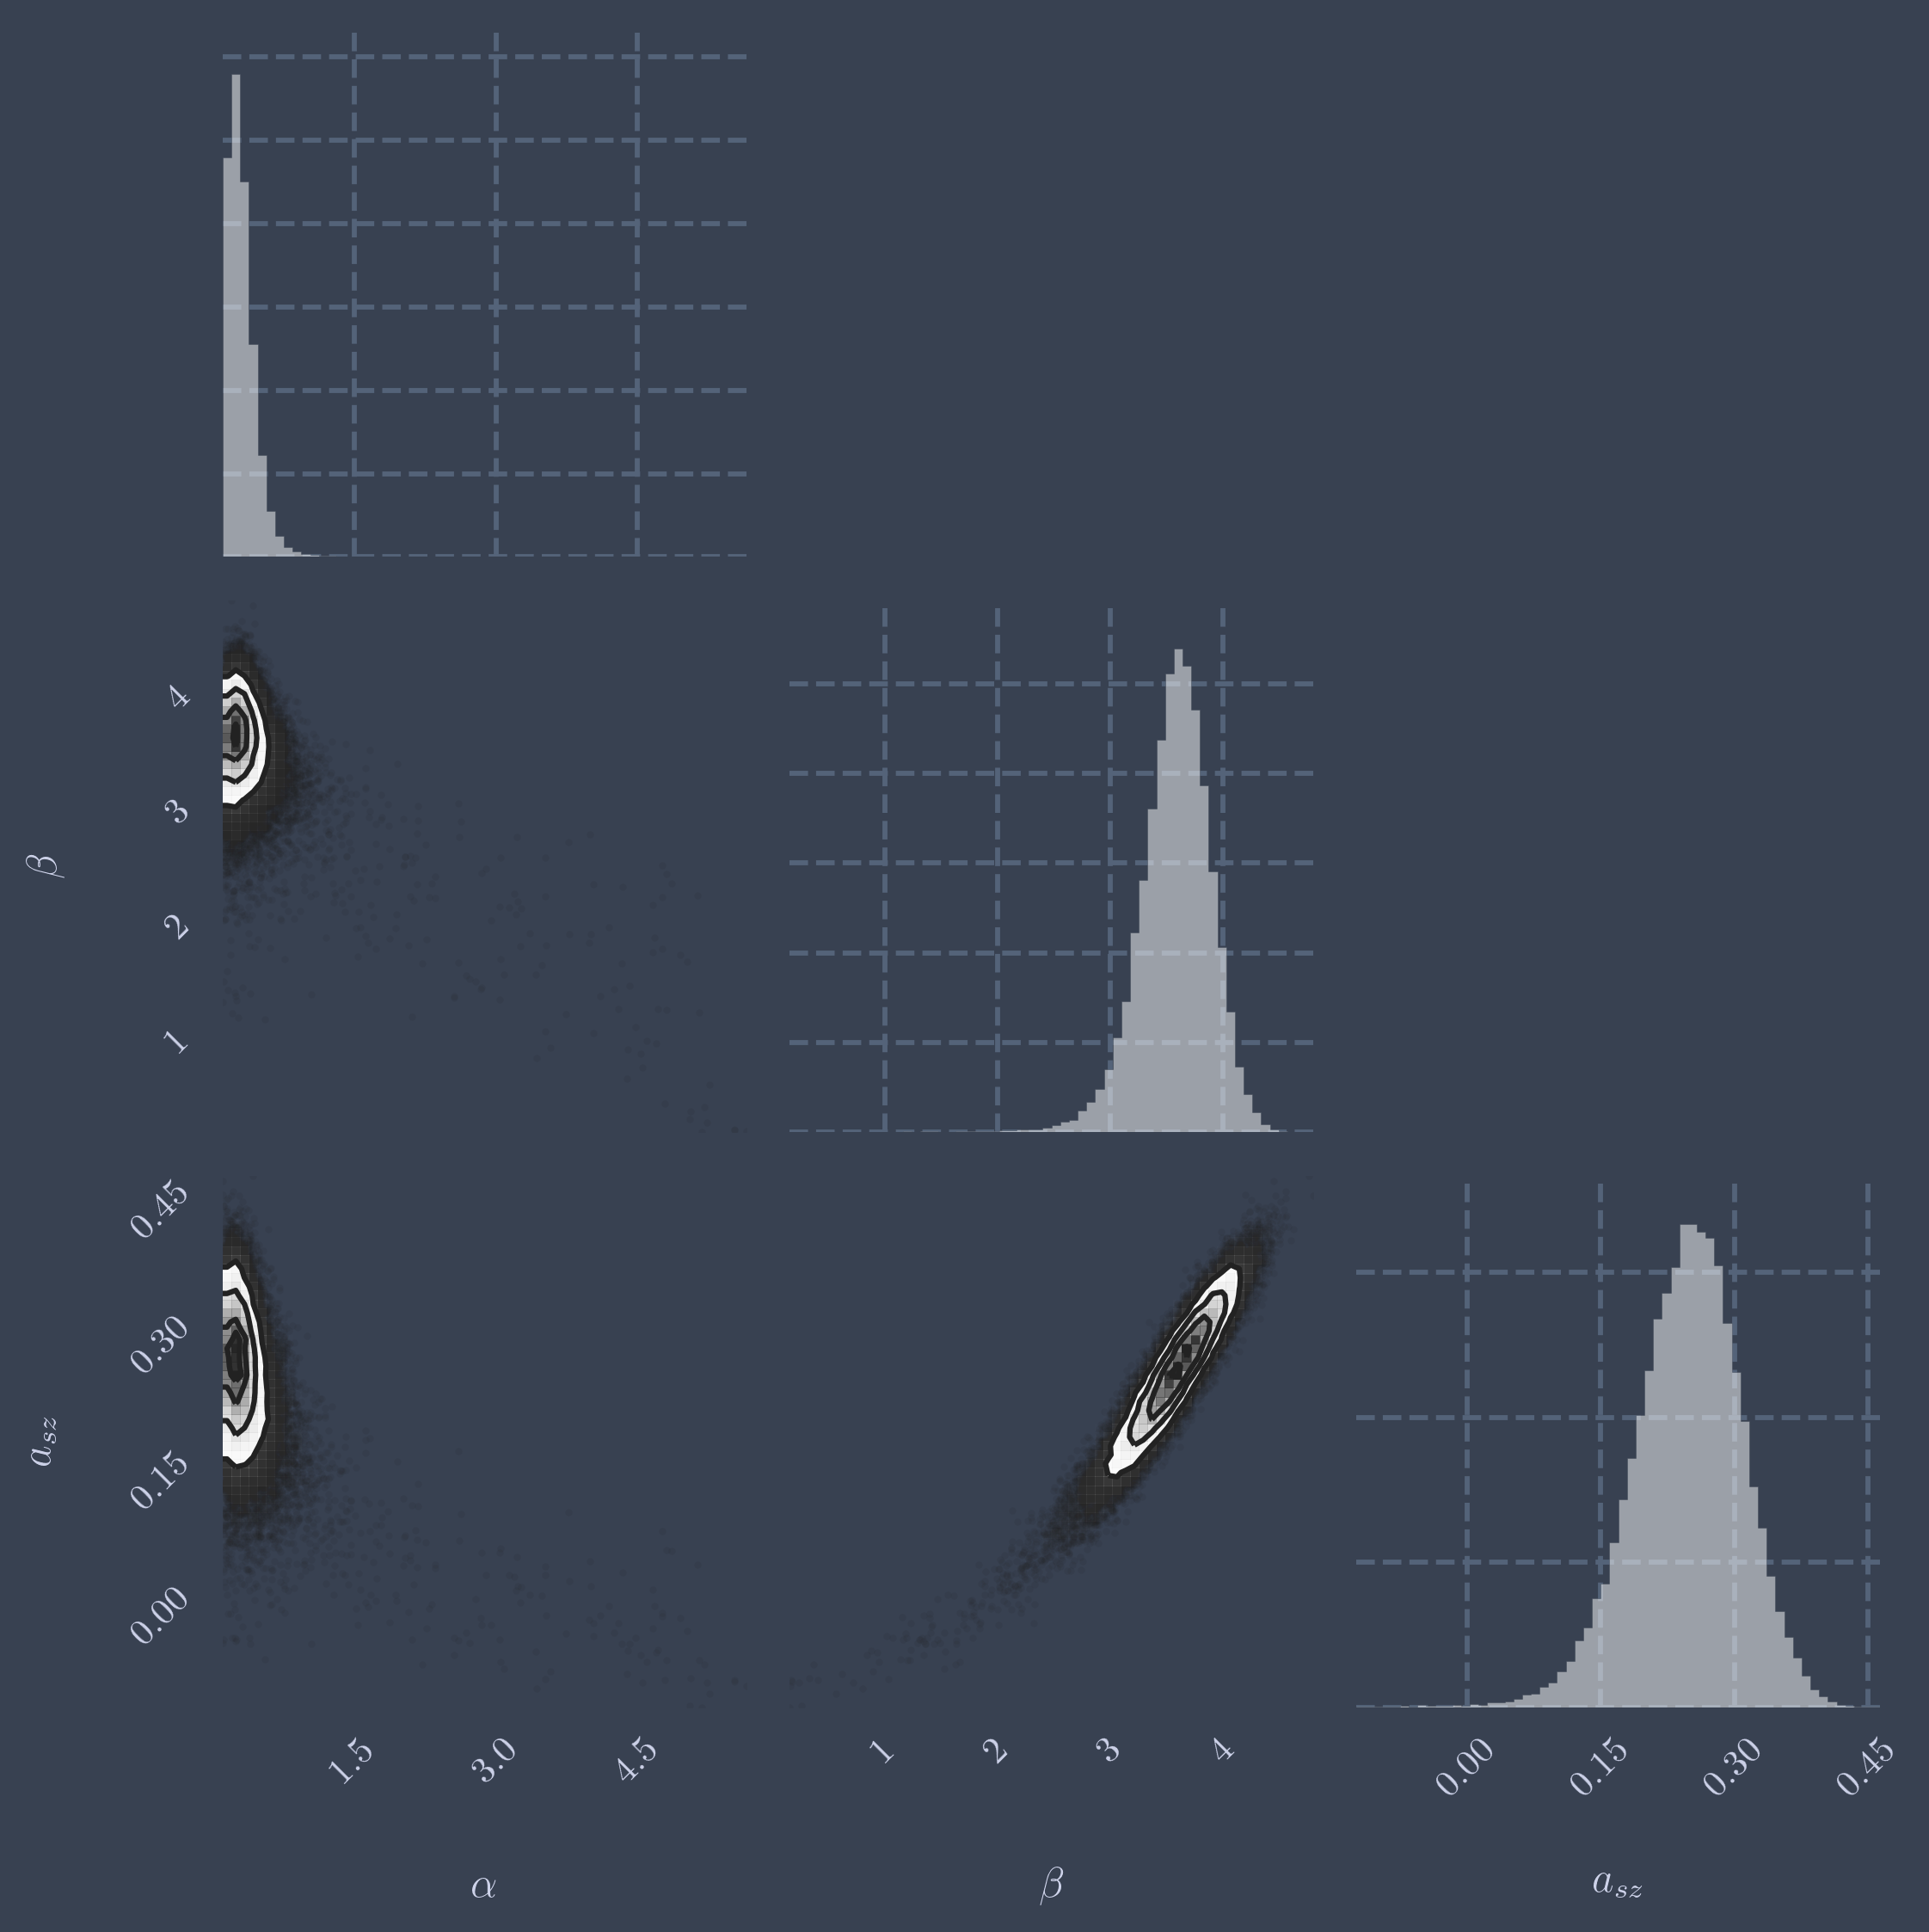

In [71]:
hist_kwargs = {'histtype':'stepfilled', 'alpha':0.5, 'color':'#ffffff'}
#hist2d_kwargs = {'cmap':cmap}
fig = corner.corner(flat_samples,
                    bins=60,
                    labels=param_names,
                    hist_kwargs=hist_kwargs)

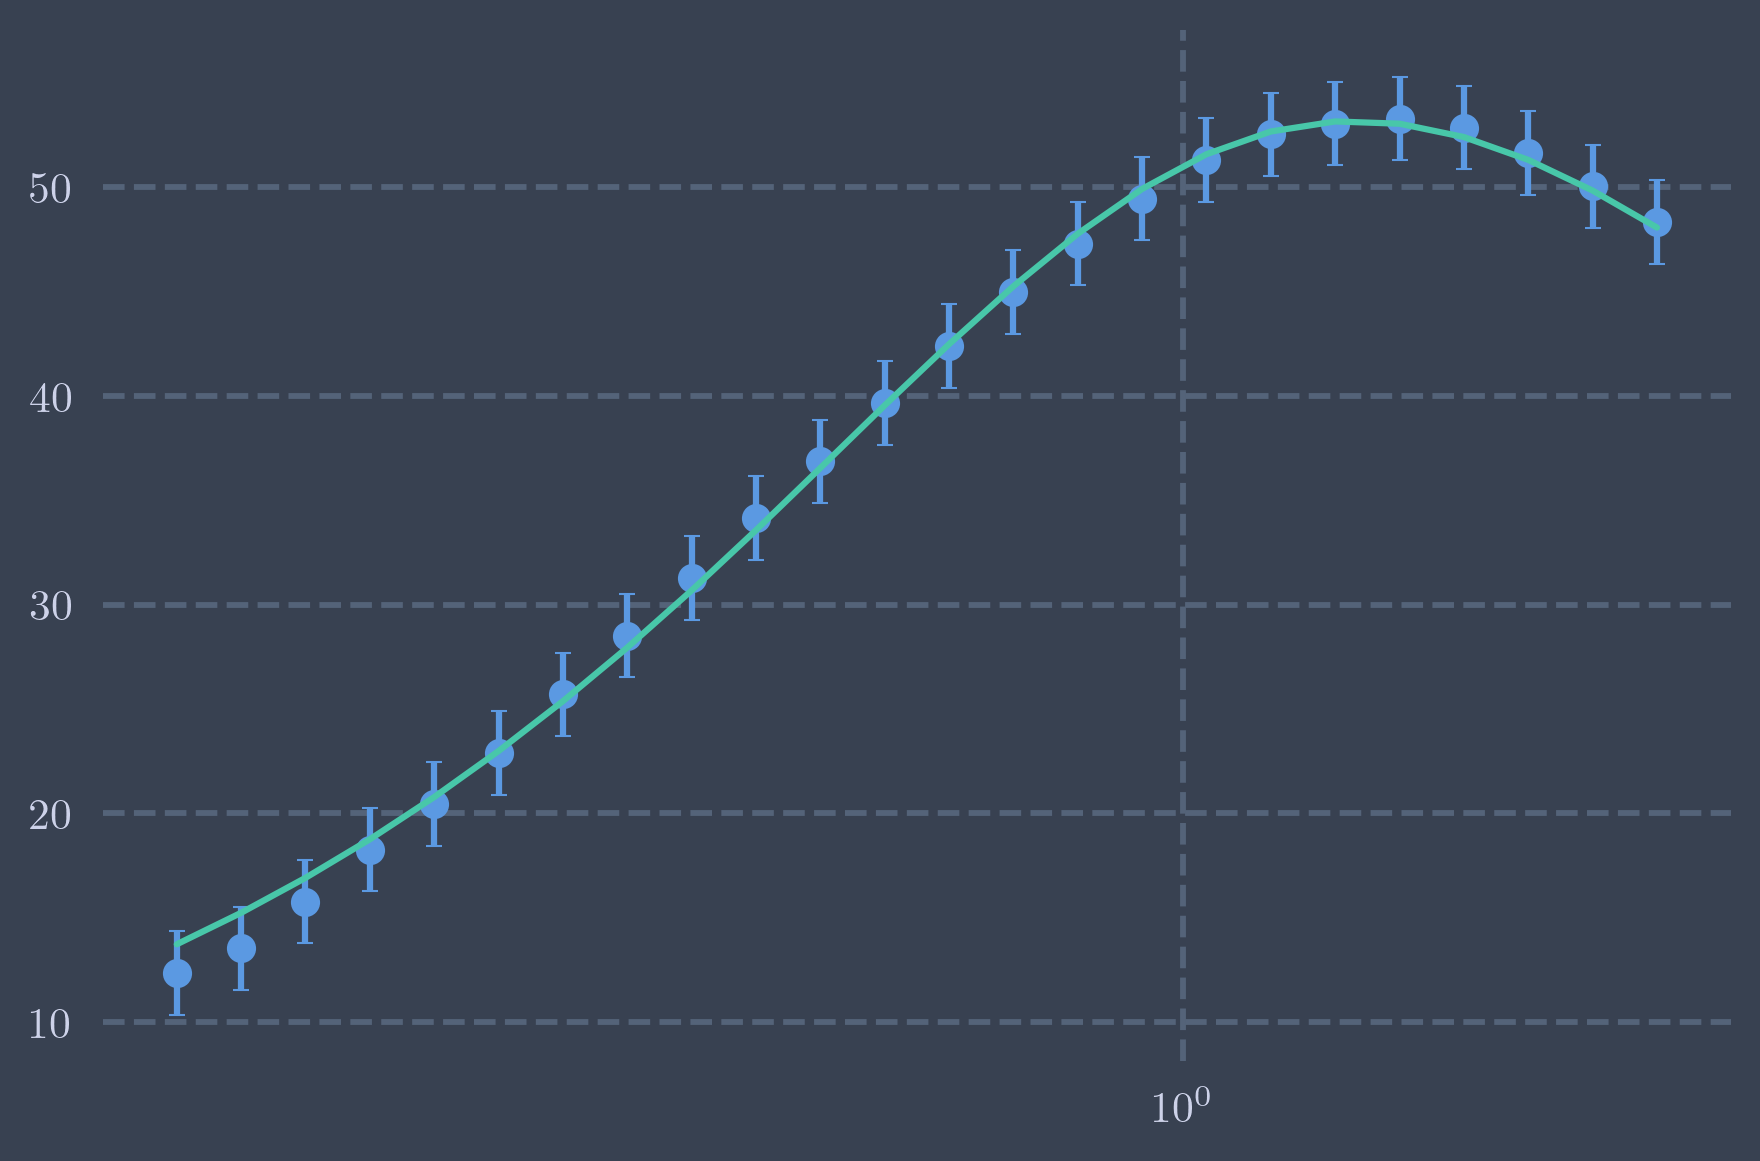

In [78]:
plt.errorbar(rs, sim_stack, yerr=sim_errs, linestyle='',
             color=colors[0], capsize=2, capthick=0.5, marker='o')
plt.plot(rs, emulator(best_fit[None, :]), color=colors[1], zorder=3)
plt.xscale('log')
plt.gcf().set_size_inches(6, 4)
pass

In [87]:
sim_stacked_mass = sim_data.masses.mean()
print(sim_stacked_mass/1e14)

2.0669325009935213


In [88]:
model_stacked_mass = model.weak_lensing_avg_mass(best_fit[2:])[0]
print(model_stacked_mass/1e14)

2.4109134683191256


In [92]:
print(model_stacked_mass/sim_stacked_mass)

1.166420996892865
